In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import gmean
from datetime import datetime

# Data read

In [2]:
df = pd.read_csv('claims_sample_data_cleared.csv')

In [3]:
df.head(3)

,Unnamed: 0,MONTH,SERVICE_CATEGORY,CLAIM_SPECIALTY,PAYER,PAID_AMOUNT,CLAIM_SPECIALTY_formatted,CLAIM_SPECIALTY_final,pairednum
0,0,201801,AncillaryFFS,null_specialty,Payer F,4281,null_specialty,null_specialty,1
1,1,201801,AncillaryFFS,null_specialty,Payer H,2221,null_specialty,null_specialty,1
2,2,201801,AncillaryFFS,null_specialty,Payer O,3937,null_specialty,null_specialty,1


In [4]:
df1 = df.groupby(['MONTH']).agg({'PAID_AMOUNT':'sum'}).reset_index()

In [5]:
df1.describe()

,MONTH,PAID_AMOUNT
count,30.000000,3.000000e+01
mean,201885.900000,6.443763e+06
std,75.207002,9.802009e+05
min,201801.000000,2.913437e+06
25%,201808.250000,5.952717e+06
50%,201903.500000,6.512721e+06
75%,201910.750000,7.058377e+06
max,202006.000000,8.558681e+06


In [6]:
df1.index = pd.to_datetime(df1['MONTH'], format='%Y%m')

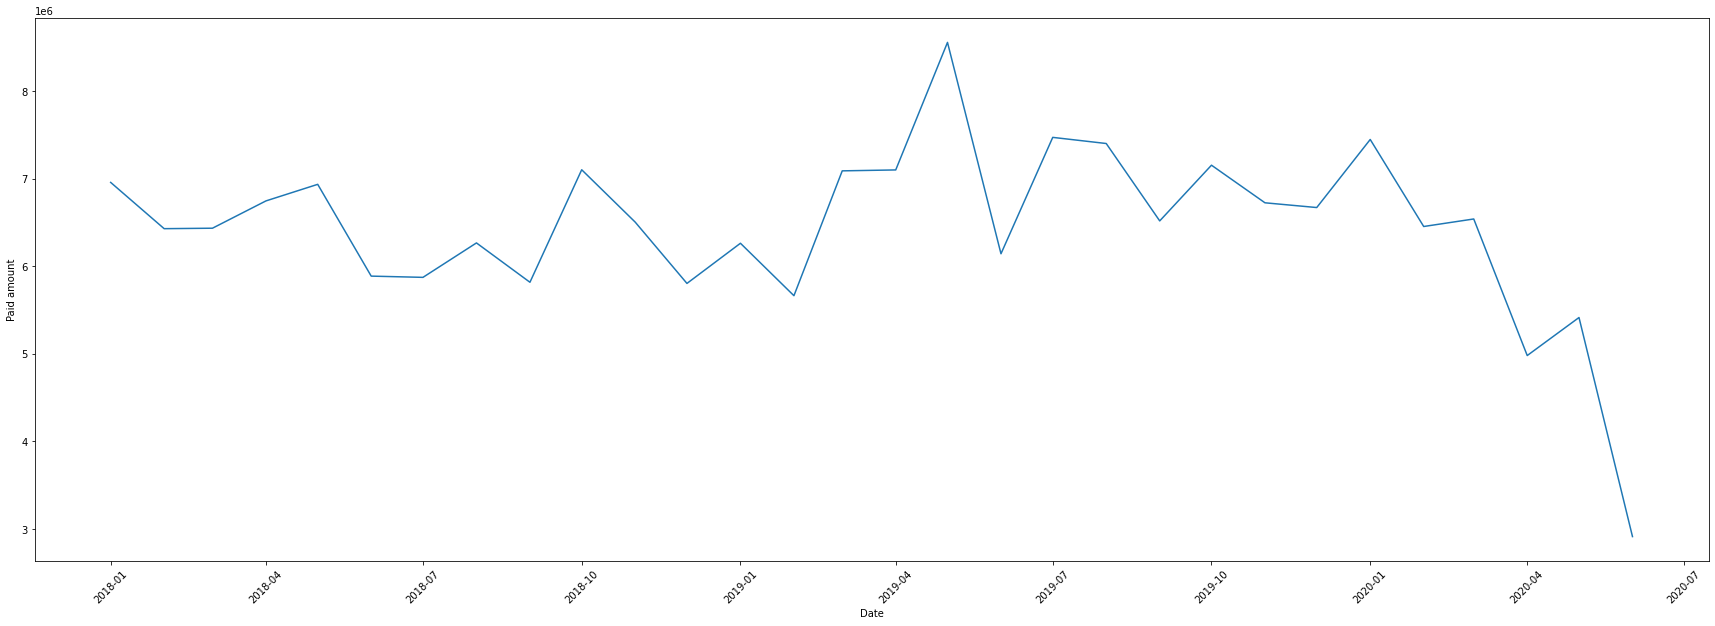

In [7]:
plt.figure(figsize=(30,10))

plt.ylabel('Paid amount')
plt.xlabel('Date')
plt.xticks(rotation=45)

plt.plot(df1.index, df1['PAID_AMOUNT'], )

# Data historical split

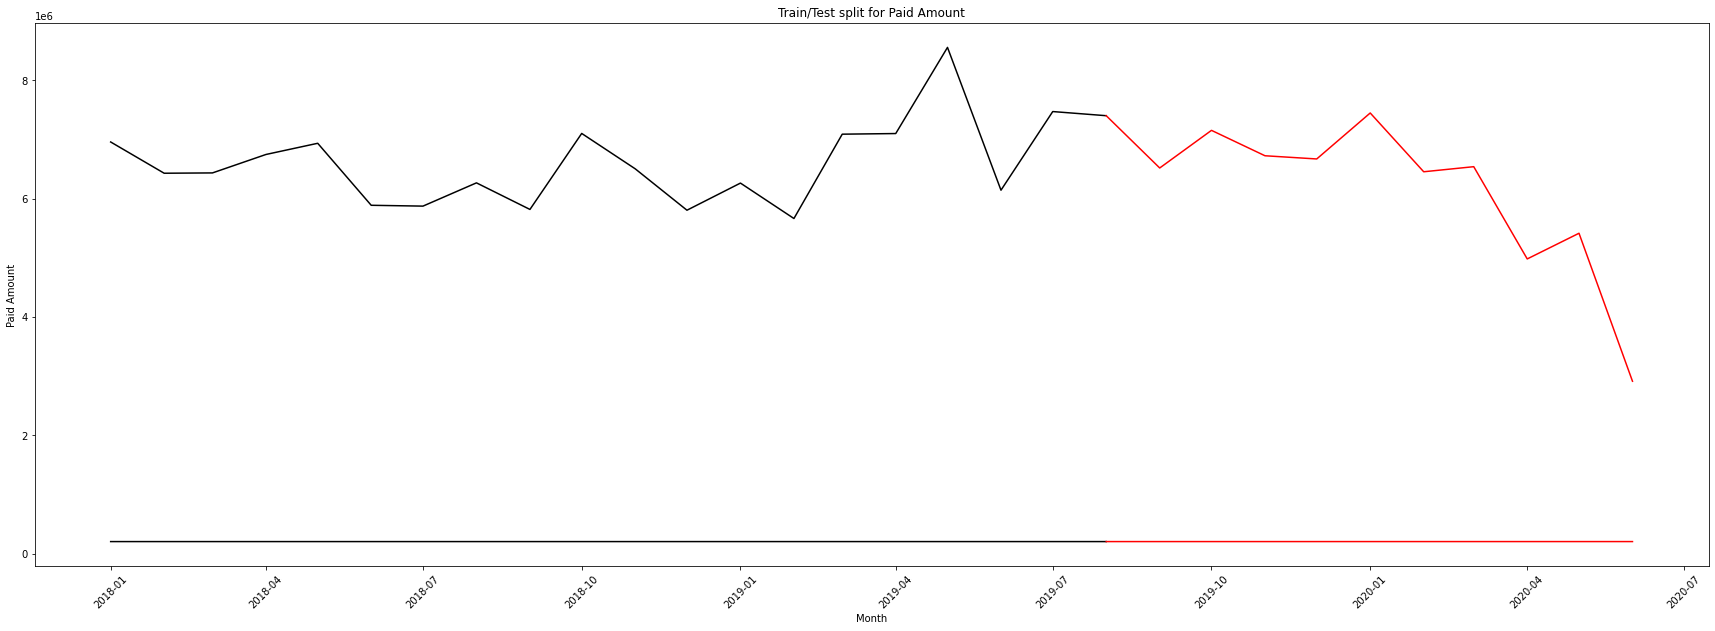

In [8]:
plt.figure(figsize=(30,10))

train = df1.iloc[0:20]
test = df1.iloc[19:]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Paid Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.title("Train/Test split for Paid Amount")
plt.show()

# Seasonality and autocorrelation

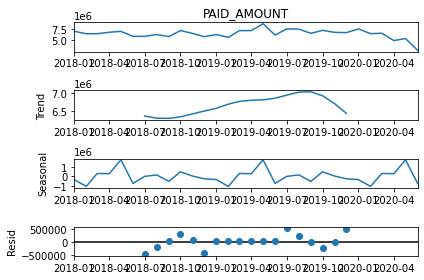

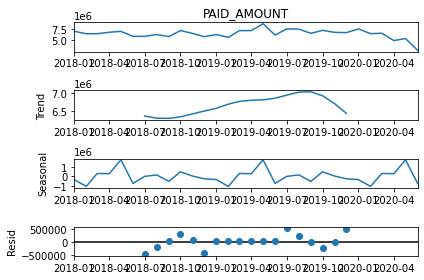

In [9]:
result = seasonal_decompose(df1['PAID_AMOUNT'])
result.plot()

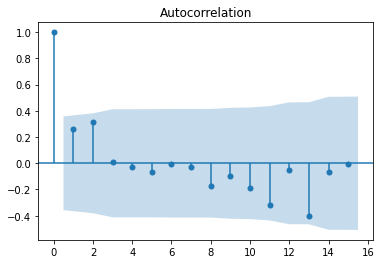

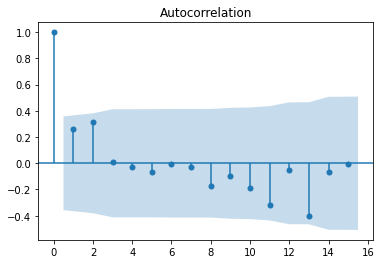

In [10]:
plot_acf(df1['PAID_AMOUNT'])

Output:
* Slow changing trend, approximately linear, year seasonability, residials are not correlated
* There are no significant autocorrelated periods
* Linear and simple models are supposed to give better results in comparison to complex autocorrelated

# Simple prediction without validation (for more info check appendix)

In [11]:
df1['12m_growth_rate'] = df1['PAID_AMOUNT'].shift(0)/df1['PAID_AMOUNT'].shift(12)

In [12]:
df1['month_num'] = df1['MONTH'].apply(lambda x: x%100)

In [13]:
df1['Time'] = np.arange(len(df1.index))

In [14]:
from sklearn.linear_model import LinearRegression
X = df1.loc[:, ['Time']]  
y = df1['PAID_AMOUNT']  
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [15]:
linear_rmse = np.sqrt(mean_squared_error(df1["PAID_AMOUNT"].values, y_pred))
print("RMSE: ",linear_rmse)

RMSE:  941417.3682109092


# Prediction to the end of 2020

In [16]:
pred = []
last_num = np.max(X)
covid_adj = gmean(df1['12m_growth_rate'][-3:])

for i in range(6):
    cur_index = last_num + i + 1
    cur_date = datetime(year=2020, month=7+i, day=1)
    linear_prediction = model.predict([cur_index])*covid_adj
    print(linear_prediction[0])
    df1.loc[cur_date] = [cur_date.strftime('%Y%m'),linear_prediction[0],0,0,0]

3613372.8772025965
3599204.9739456805
3585037.0706887646
3570869.167431849
3556701.264174933
3542533.360918017


Graph is on the last cell

# Appendix - autocorrelated models

## Train-test split

In [17]:
train = df1.iloc[0:20]
test = df1.iloc[20:30]
linear_prediction = df1.iloc[30:]

In [18]:
test

,MONTH,PAID_AMOUNT,12m_growth_rate,month_num,Time
MONTH,,,,,
2019-09-01,201909,6519659.0,1.120465,9,20
2019-10-01,201910,7156007.0,1.007346,10,21
2019-11-01,201911,6726444.0,1.033918,11,22
2019-12-01,201912,6672237.0,1.149307,12,23
2020-01-01,202001,7449768.0,1.189247,1,24
2020-02-01,202002,6455708.0,1.139534,2,25
2020-03-01,202003,6541616.0,0.922478,3,26
2020-04-01,202004,4981590.0,0.701443,4,27
2020-05-01,202005,5415924.0,0.632799,5,28


# ARMA model

In [19]:
y = train['PAID_AMOUNT']

In [20]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [21]:
y_pred1 = ARMAmodel.get_forecast(len(test.index))
y_pred_df1 = y_pred1.conf_int(alpha = 0.05) 
y_pred_df1["Predictions"] = ARMAmodel.predict(start = y_pred_df1.index[0], end = y_pred_df1.index[-1])
y_pred_df1.index = test.index
y_pred_out1 = y_pred_df1["Predictions"] 

In [22]:
arma_rmse = np.sqrt(mean_squared_error(test["PAID_AMOUNT"].values, y_pred_df1["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  1626031.4511498376


# ARIMA

In [23]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred2 = ARIMAmodel.get_forecast(len(test.index))
y_pred_df2 = y_pred2.conf_int(alpha = 0.05) 
y_pred_df2["Predictions"] = ARIMAmodel.predict(start = y_pred_df2.index[0], end = y_pred_df2.index[-1])
y_pred_df2.index = test.index
y_pred_out2 = y_pred_df2["Predictions"] 

/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/georgiirak/opt/anaconda3/lib

In [24]:
arima_rmse = np.sqrt(mean_squared_error(test["PAID_AMOUNT"].values, y_pred_df2["Predictions"]))
print("RMSE: ",arima_rmse)

RMSE:  4043357.350139265


# SARIMAX

In [25]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred3 = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df3 = y_pred3.conf_int(alpha = 0.05) 
y_pred_df3["Predictions"] = SARIMAXmodel.predict(start = y_pred_df3.index[0], end = y_pred_df3.index[-1])
y_pred_df3.index = test.index
y_pred_out3 = y_pred_df3["Predictions"] 

/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/georgiirak/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except fo

In [26]:
sarimax_rmse = np.sqrt(mean_squared_error(test["PAID_AMOUNT"].values, y_pred_df3["Predictions"]))
print("RMSE: ",sarimax_rmse)

RMSE:  490602857.4985346


# Results

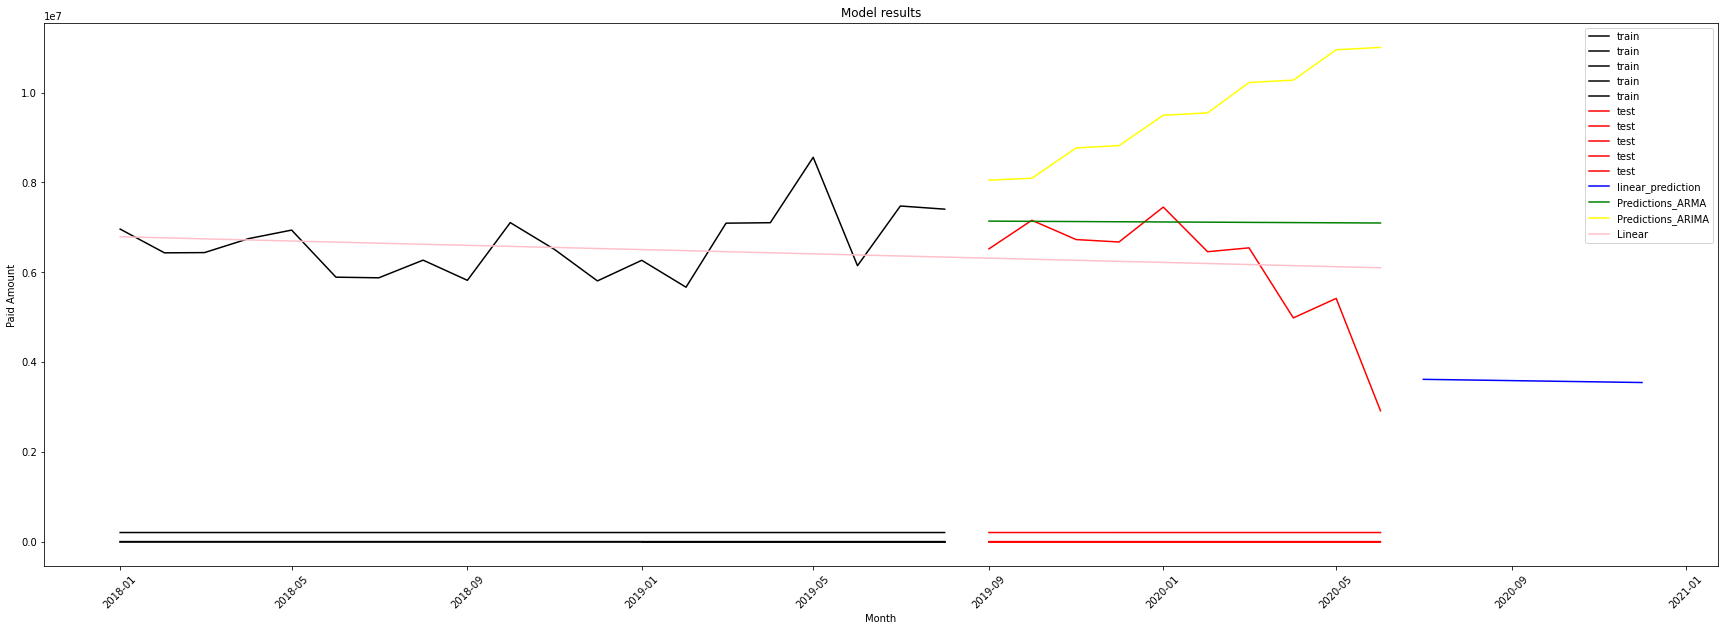

In [33]:
plt.figure(figsize=(30,10))

plt.plot(train['PAID_AMOUNT'], color = "black", label = 'train')
plt.plot(test['PAID_AMOUNT'], color = "red", label = 'test')
plt.plot(linear_prediction['PAID_AMOUNT'], color = "blue", label = 'linear_prediction')
plt.plot(y_pred_out1, color='green', label = 'Predictions_ARMA')
plt.plot(y_pred_out2, color='yellow', label = 'Predictions_ARIMA')
plt.plot(y_pred, color = 'pink', label = 'Linear')
plt.ylabel('Paid Amount')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.title("Model results")
plt.legend()
plt.show()

Output:
* Autocorrelated functions show very high RMSE even in comparison with linear or constant models
* Physical meaning of it - Apr-Jun of 2020th showed outliered data 
* I reccomend to use simple models without validation to count for COVID effect